# Modeling spectral bands with `climlab`

Here is a brief introduction to the `climlab.BandRCModel` process.

This is a model that divides the spectrum into 7 distinct bands: three shortwave and four longwave.

As we will see, the process works much like the familiar `climlab.RadiativeConvectiveModel`.


## About the spectra

The shortwave is divided into three channels:

- Channel 0 is the Hartley and Huggins band (extreme UV, 200 - 340 nm, 1% of total flux, strong ozone absorption)
- Channel 1 is Chappuis band (450 - 800 nm, 27% of total flux, moderate ozone absorption)
- Channel 2 is remaining radiation (72% of total flux, largely in the visible range, no ozone absorption)

The longwave is divided into four bands:

- Band 0 is the window region (between 8.5 and 11 $\mu$m), 17% of total flux.
- Band 1 is the CO2 absorption channel (the band of strong absorption by CO2 around 15 $\mu$m), 15% of total flux
- Band 2 is a weak water vapor absorption channel, 35% of total flux
- Band 3 is a strong water vapor absorption channel, 33% of total flux

The longwave decomposition is not as easily related to specific wavelengths, as in reality there is a lot of overlap between H$_2$O and CO$_2$ absorption features (as well as absorption by other greenhouse gases such as CH$_4$ and N$_2$O that we are not representing).

### Example usage of the spectral model

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import climlab
from climlab import constants as const

First try a model with all default parameters. Usage is very similar to the familiar `RadiativeConvectiveModel`.

In [2]:
col1 = climlab.BandRCModel()
print(col1)

climlab Process of type <class 'climlab.model.column.BandRCModel'>. 
State variables and domain shapes: 
  Ts: (1,) 
  Tatm: (30,) 
The subprocess tree: 
Untitled: <class 'climlab.model.column.BandRCModel'>
   LW: <class 'climlab.radiation.nband.FourBandLW'>
   SW: <class 'climlab.radiation.nband.ThreeBandSW'>
   insolation: <class 'climlab.radiation.insolation.FixedInsolation'>
   convective adjustment: <class 'climlab.convection.convadj.ConvectiveAdjustment'>
   H2O: <class 'climlab.radiation.water_vapor.ManabeWaterVapor'>



Check out the list of subprocesses.

We now have a process called `H2O`, in addition to things we've seen before.

This model keeps track of water vapor. We see the specific humidity in the list of state variables:

In [3]:
col1.state

AttrDict({'Ts': Field([288.]), 'Tatm': Field([200.        , 202.68965517, 205.37931034, 208.06896552,
       210.75862069, 213.44827586, 216.13793103, 218.82758621,
       221.51724138, 224.20689655, 226.89655172, 229.5862069 ,
       232.27586207, 234.96551724, 237.65517241, 240.34482759,
       243.03448276, 245.72413793, 248.4137931 , 251.10344828,
       253.79310345, 256.48275862, 259.17241379, 261.86206897,
       264.55172414, 267.24137931, 269.93103448, 272.62068966,
       275.31034483, 278.        ])})

The water vapor field is initialized to zero. The `H2O` process will set the specific humidity field at every timestep to a specified profile. More on that below. For now, let's compute a radiative equilibrium state.

In [4]:
col1.integrate_years(2)

Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.


In [5]:
# Check for energy balance
col1.ASR - col1.OLR

Field([-923.92237128])

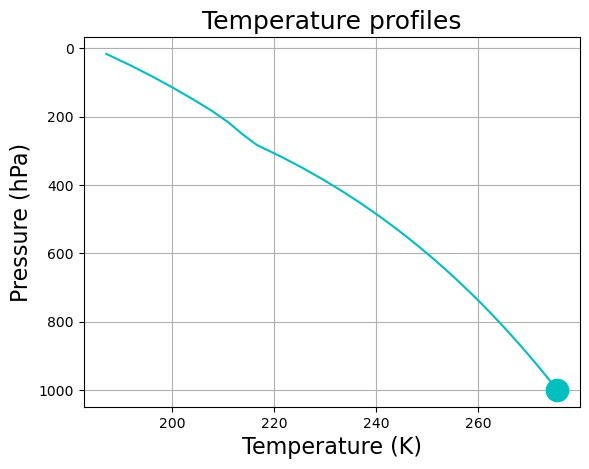

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot( col1.Tatm, col1.lev, 'c-', label='default' )
ax.plot( col1.Ts, climlab.constants.ps, 'co', markersize=16 )
ax.invert_yaxis()
ax.set_xlabel('Temperature (K)', fontsize=16)
ax.set_ylabel('Pressure (hPa)', fontsize=16 )
ax.set_title('Temperature profiles', fontsize = 18)
ax.grid()

By default this model has convective adjustment.  We can set the adjusted lapse rate by passing a parameter when we create the model.

The model currently has no ozone (so there is no stratosphere). Not very realistic!


More reasonable-looking troposphere, but still no stratosphere.

### About the radiatively active gases

The Band model is aware of three different absorbing gases: O3 (ozone), CO2, and H2O (water vapor). The abundances of these gases are stored in a dictionary of arrays as follows:

In [7]:
col1.absorber_vmr

{'CO2': Field([0.00038, 0.00038, 0.00038, 0.00038, 0.00038, 0.00038, 0.00038,
        0.00038, 0.00038, 0.00038, 0.00038, 0.00038, 0.00038, 0.00038,
        0.00038, 0.00038, 0.00038, 0.00038, 0.00038, 0.00038, 0.00038,
        0.00038, 0.00038, 0.00038, 0.00038, 0.00038, 0.00038, 0.00038,
        0.00038, 0.00038]),
 'O3': Field([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'H2O': Field([5.00000000e-06, 5.00000000e-06, 5.00000000e-06, 5.00000000e-06,
        5.00000000e-06, 5.00000000e-06, 6.38590233e-06, 9.08848690e-06,
        1.33273826e-05, 2.34389689e-05, 3.84220914e-05, 5.95564299e-05,
        8.82144990e-05, 1.25843839e-04, 1.73951159e-04, 2.34088411e-04,
        3.07840683e-04, 3.96815735e-04, 5.02635028e-04, 6.26926041e-04,
        7.71315753e-04, 9.37425100e-04, 1.12686431e-03, 1.34122899e-03,
        1.58209684e-03, 1.85102493e-03, 2.14954752e-03, 2.47917415e-03,
        2.84138824e-03, 3.

Ozone and CO2 are both specified in the model. The default, as you see above, is zero ozone, and constant (well-mixed) CO2 at a volume mixing ratio of 3.8E-4 or 380 ppm.

Water vapor is handled differently: it is determined by the model at each timestep. We make the following assumptions, following a classic paper on radiative-convective equilibrium by Manabe and Wetherald (J. Atmos. Sci. 1967):

- the relative humidity just above the surface is fixed at 77% (can be changed of course... see the parameter `col1.relative_humidity`
- water vapor drops off linearly with pressure
- there is a small specified amount of water vapor in the stratosphere.

## Putting in some ozone

In [8]:
#  Put in some ozone
import xarray as xr

ozonepath = "http://thredds.atmos.albany.edu:8080/thredds/dodsC/CLIMLAB/ozone/apeozone_cam3_5_54.nc"
ozone = xr.open_dataset(ozonepath)
ozone

<xarray.Dataset> Size: 93MB
Dimensions:    (lev: 59, lon: 128, lat: 64, time: 12)
Coordinates:
  * lev        (lev) float64 472B 0.2842 0.3253 0.3719 ... 849.5 959.0 1.004e+03
  * lon        (lon) float64 1kB 0.0 2.812 5.625 8.438 ... 351.6 354.4 357.2
  * lat        (lat) float64 512B -87.86 -85.1 -82.31 ... 82.31 85.1 87.86
  * time       (time) float64 96B 4.382e+04 4.384e+04 ... 4.412e+04 4.415e+04
Data variables:
    P0         float64 8B ...
    date       (time) int32 48B ...
    datesec    (time) int32 48B ...
    OZONE_old  (time, lat, lev, lon) float64 46MB ...
    OZONE      (time, lev, lat, lon) float64 46MB ...
Attributes:
    Conventions:                     NCAR-CSM
    Source:                          AMIP II (symmetric for APE project)
    Written_By:                      olson
    Date_Written:                    August 22 2003
    Host:                            zen
    Command:                         ncgen
    history:                         Wed Jul 30 08:35:58 2008: ncrename -v OZ...
    DODS_EXTRA.Unlimited_Dimension:  time

In [9]:
#  Dimensions of the ozone file
lat = ozone.lat
lon = ozone.lon
lev = ozone.lev


In [10]:
# Taking annual, zonal, and global averages of the ozone data
O3_zon = ozone.OZONE.mean(dim=("time","lon"))

weight_ozone = np.cos(np.deg2rad(ozone.lat)) / np.cos(np.deg2rad(ozone.lat)).mean(dim='lat')
O3_global = (O3_zon * weight_ozone).mean(dim='lat')

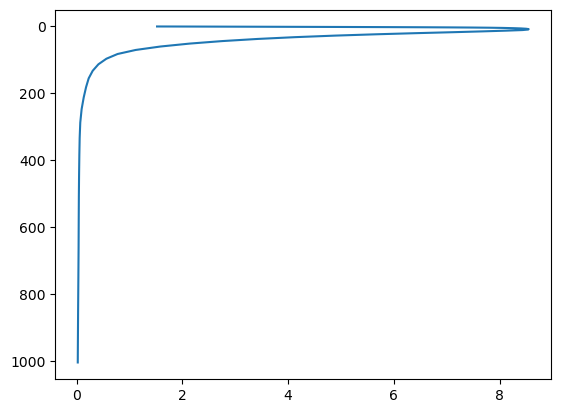

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot( O3_global*1E6, lev)
ax.invert_yaxis()

We are going to create another instance of the model, this time using the same vertical coordinates as the ozone data.

In [12]:
#  Create the column with appropriate vertical coordinate, surface albedo and convective adjustment
col2 = climlab.BandRCModel(lev=lev)
print(col2)

climlab Process of type <class 'climlab.model.column.BandRCModel'>. 
State variables and domain shapes: 
  Ts: (1,) 
  Tatm: (59,) 
The subprocess tree: 
Untitled: <class 'climlab.model.column.BandRCModel'>
   LW: <class 'climlab.radiation.nband.FourBandLW'>
   SW: <class 'climlab.radiation.nband.ThreeBandSW'>
   insolation: <class 'climlab.radiation.insolation.FixedInsolation'>
   convective adjustment: <class 'climlab.convection.convadj.ConvectiveAdjustment'>
   H2O: <class 'climlab.radiation.water_vapor.ManabeWaterVapor'>



In [13]:
#  Set the ozone mixing ratio
col2.absorber_vmr['O3'] = O3_global.values

In [14]:
#  Run the model out to equilibrium!
col2.integrate_years(2.)

Integrating for 730 steps, 730.4844 days, or 2.0 years.
Total elapsed time is 1.9986737567564754 years.


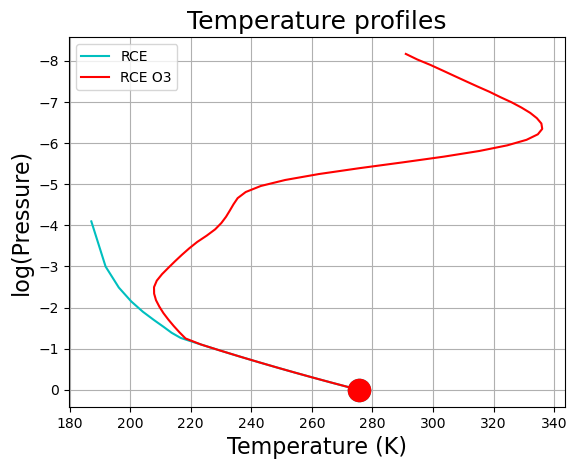

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot( col1.Tatm, np.log(col1.lev/1000), 'c-', label='RCE' )
ax.plot( col1.Ts, 0, 'co', markersize=16 )
ax.plot(col2.Tatm, np.log(col2.lev/1000), 'r-', label='RCE O3' )
ax.plot(col2.Ts, 0, 'ro', markersize=16 )
ax.invert_yaxis()
ax.set_xlabel('Temperature (K)', fontsize=16)
ax.set_ylabel('log(Pressure)', fontsize=16 )
ax.set_title('Temperature profiles', fontsize = 18)
ax.grid()
ax.legend()

Once we include ozone we get a well-defined stratosphere. We can also a slight cooling effect in the troposphere.

Things to consider / try:

- Here we used the global annual mean Q = 341.3 W m$^{-2}$. We might want to consider latitudinal or seasonal variations in Q.
- We also used the global annual mean ozone profile! Ozone varies tremendously in latitude and by season. That information is all contained in the ozone data file we opened above. We might explore the effects of those variations.
- We can calculate climate sensitivity in this model by doubling the CO2 concentration and re-running out to the new equilibrium. Does the amount of ozone affect the climate sensitivity?  (example below)
- An important shortcoming of the model: there are no clouds! (that would be the next step in the hierarchy of column models)
- Clouds would act both in the shortwave (increasing the albedo, cooling the climate) and in the longwave (greenhouse effect, warming the climate). Which effect is stronger depends on the vertical structure of the clouds (high or low clouds) and their optical properties (e.g. thin cirrus clouds are nearly transparent to solar radiation but are good longwave absorbers).

In [16]:
col3 = climlab.process_like(col2)
print(col3)

climlab Process of type <class 'climlab.model.column.BandRCModel'>. 
State variables and domain shapes: 
  Ts: (1,) 
  Tatm: (59,) 
The subprocess tree: 
Untitled: <class 'climlab.model.column.BandRCModel'>
   LW: <class 'climlab.radiation.nband.FourBandLW'>
   SW: <class 'climlab.radiation.nband.ThreeBandSW'>
   insolation: <class 'climlab.radiation.insolation.FixedInsolation'>
   convective adjustment: <class 'climlab.convection.convadj.ConvectiveAdjustment'>
   H2O: <class 'climlab.radiation.water_vapor.ManabeWaterVapor'>



In [17]:
# Let's double CO2.
col3.absorber_vmr['CO2'] *= 2.

In [18]:
col3.compute_diagnostics()
print('The radiative forcing for doubling CO2 is %f W/m2.' % (col2.OLR - col3.OLR))

The radiative forcing for doubling CO2 is 5.240631 W/m2.


/var/folders/dl/j7hb106d36n501mrm8j646bxpf4y1c/T/ipykernel_18068/1740494173.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('The radiative forcing for doubling CO2 is %f W/m2.' % (col2.OLR - col3.OLR))


In [19]:
col3.integrate_years(3)

Integrating for 1095 steps, 1095.7266 days, or 3 years.
Total elapsed time is 4.996684391891189 years.


In [20]:
col3.ASR - col3.OLR

Field([-927.88034934])

In [21]:
print('The Equilibrium Climate Sensitivity is %f K.' % (col3.Ts - col2.Ts))

The Equilibrium Climate Sensitivity is 2.758433 K.


/var/folders/dl/j7hb106d36n501mrm8j646bxpf4y1c/T/ipykernel_18068/4143858341.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('The Equilibrium Climate Sensitivity is %f K.' % (col3.Ts - col2.Ts))


In [22]:
col4 = climlab.process_like(col1)
print(col4)

climlab Process of type <class 'climlab.model.column.BandRCModel'>. 
State variables and domain shapes: 
  Ts: (1,) 
  Tatm: (30,) 
The subprocess tree: 
Untitled: <class 'climlab.model.column.BandRCModel'>
   LW: <class 'climlab.radiation.nband.FourBandLW'>
   SW: <class 'climlab.radiation.nband.ThreeBandSW'>
   insolation: <class 'climlab.radiation.insolation.FixedInsolation'>
   convective adjustment: <class 'climlab.convection.convadj.ConvectiveAdjustment'>
   H2O: <class 'climlab.radiation.water_vapor.ManabeWaterVapor'>



In [23]:
col4.absorber_vmr

{'CO2': Field([0.00038, 0.00038, 0.00038, 0.00038, 0.00038, 0.00038, 0.00038,
        0.00038, 0.00038, 0.00038, 0.00038, 0.00038, 0.00038, 0.00038,
        0.00038, 0.00038, 0.00038, 0.00038, 0.00038, 0.00038, 0.00038,
        0.00038, 0.00038, 0.00038, 0.00038, 0.00038, 0.00038, 0.00038,
        0.00038, 0.00038]),
 'O3': Field([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'H2O': Field([5.00000000e-06, 5.00000000e-06, 5.00000000e-06, 5.00000000e-06,
        5.00000000e-06, 5.00000000e-06, 6.38590233e-06, 9.08848690e-06,
        1.33273826e-05, 2.34389689e-05, 3.84220914e-05, 5.95564299e-05,
        8.82144990e-05, 1.25843839e-04, 1.73951159e-04, 2.34088411e-04,
        3.07840683e-04, 3.96815735e-04, 5.02635028e-04, 6.26926041e-04,
        7.71315753e-04, 9.37425100e-04, 1.12686431e-03, 1.34122899e-03,
        1.58209684e-03, 1.85102493e-03, 2.14954752e-03, 2.47917415e-03,
        2.84138824e-03, 3.

In [24]:
col4.absorber_vmr['CO2'] *= 2.
col4.compute_diagnostics()
print('The radiative forcing for doubling CO2 is %f W/m2.' % (col1.OLR - col4.OLR))

The radiative forcing for doubling CO2 is 17.684324 W/m2.


/var/folders/dl/j7hb106d36n501mrm8j646bxpf4y1c/T/ipykernel_18068/1060681835.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('The radiative forcing for doubling CO2 is %f W/m2.' % (col1.OLR - col4.OLR))


In [25]:
col4.integrate_years(3.)
col4.ASR - col4.OLR

Integrating for 1095 steps, 1095.7266 days, or 3.0 years.
Total elapsed time is 4.996684391891189 years.


Field([-924.4513942])

In [26]:
print('The Equilibrium Climate Sensitivity is %f K.' % (col4.Ts - col1.Ts))

The Equilibrium Climate Sensitivity is 3.180993 K.


/var/folders/dl/j7hb106d36n501mrm8j646bxpf4y1c/T/ipykernel_18068/1570834904.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('The Equilibrium Climate Sensitivity is %f K.' % (col4.Ts - col1.Ts))


Interesting that the model is MORE sensitive when ozone is set to zero.